In [164]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
%matplotlib inline  

# import local libraries
import sys
sys.path.append("/Users/research/Documents/GitHub/mfpml")


from mfpml.design_of_experiment.mf_samplers import SobolSequence
from mfpml.problems.mf_functions import *
from mfpml.utils.plot_figures import plot_mf_sampling
from mfpml.models.kriging import Kriging
from mfpml.models.mf_surrogates import ScaledKriging, CoKriging, HierarchicalKriging

In [7]:
# define function
class test(MultiFidelityFunctions): 

    num_dim = 1
    num_obj = 1
    num_cons = 0
    input_domain: np.ndarray = np.array([[0.0, 1.0]])
    design_space: dict = {"x": [0.0, 1.0]}

    def __init__(self): 
        super(test, self).__init__()

    def hf(self, x):
        obj = np.sin(20 * x) + x
        obj = np.reshape(obj, (x.shape[0], 1))
        return obj

    def lf(self, x):
        obj = 0.8 * np.sin(20 * x) + 0.5 * x + 0.5
        obj = np.reshape(obj, (x.shape[0], 1))
        return obj

In [154]:

f = test()
design_space = f.design_space
bound = f._input_domain
## test sampling part
sampler = SobolSequence(design_space=design_space, seed=17, nested=False)
samples = sampler.get_samples(num_lf_samples=15, num_hf_samples=4)

#sampler.plot_samples(figure_name='test_sampling', save_plot=True)

# sample_x = samples["hf"].to_numpy()
sample_y = {}
sample_y["hf"] = f.hf(samples["hf"])
sample_y["lf"] = f.lf(samples["lf"])

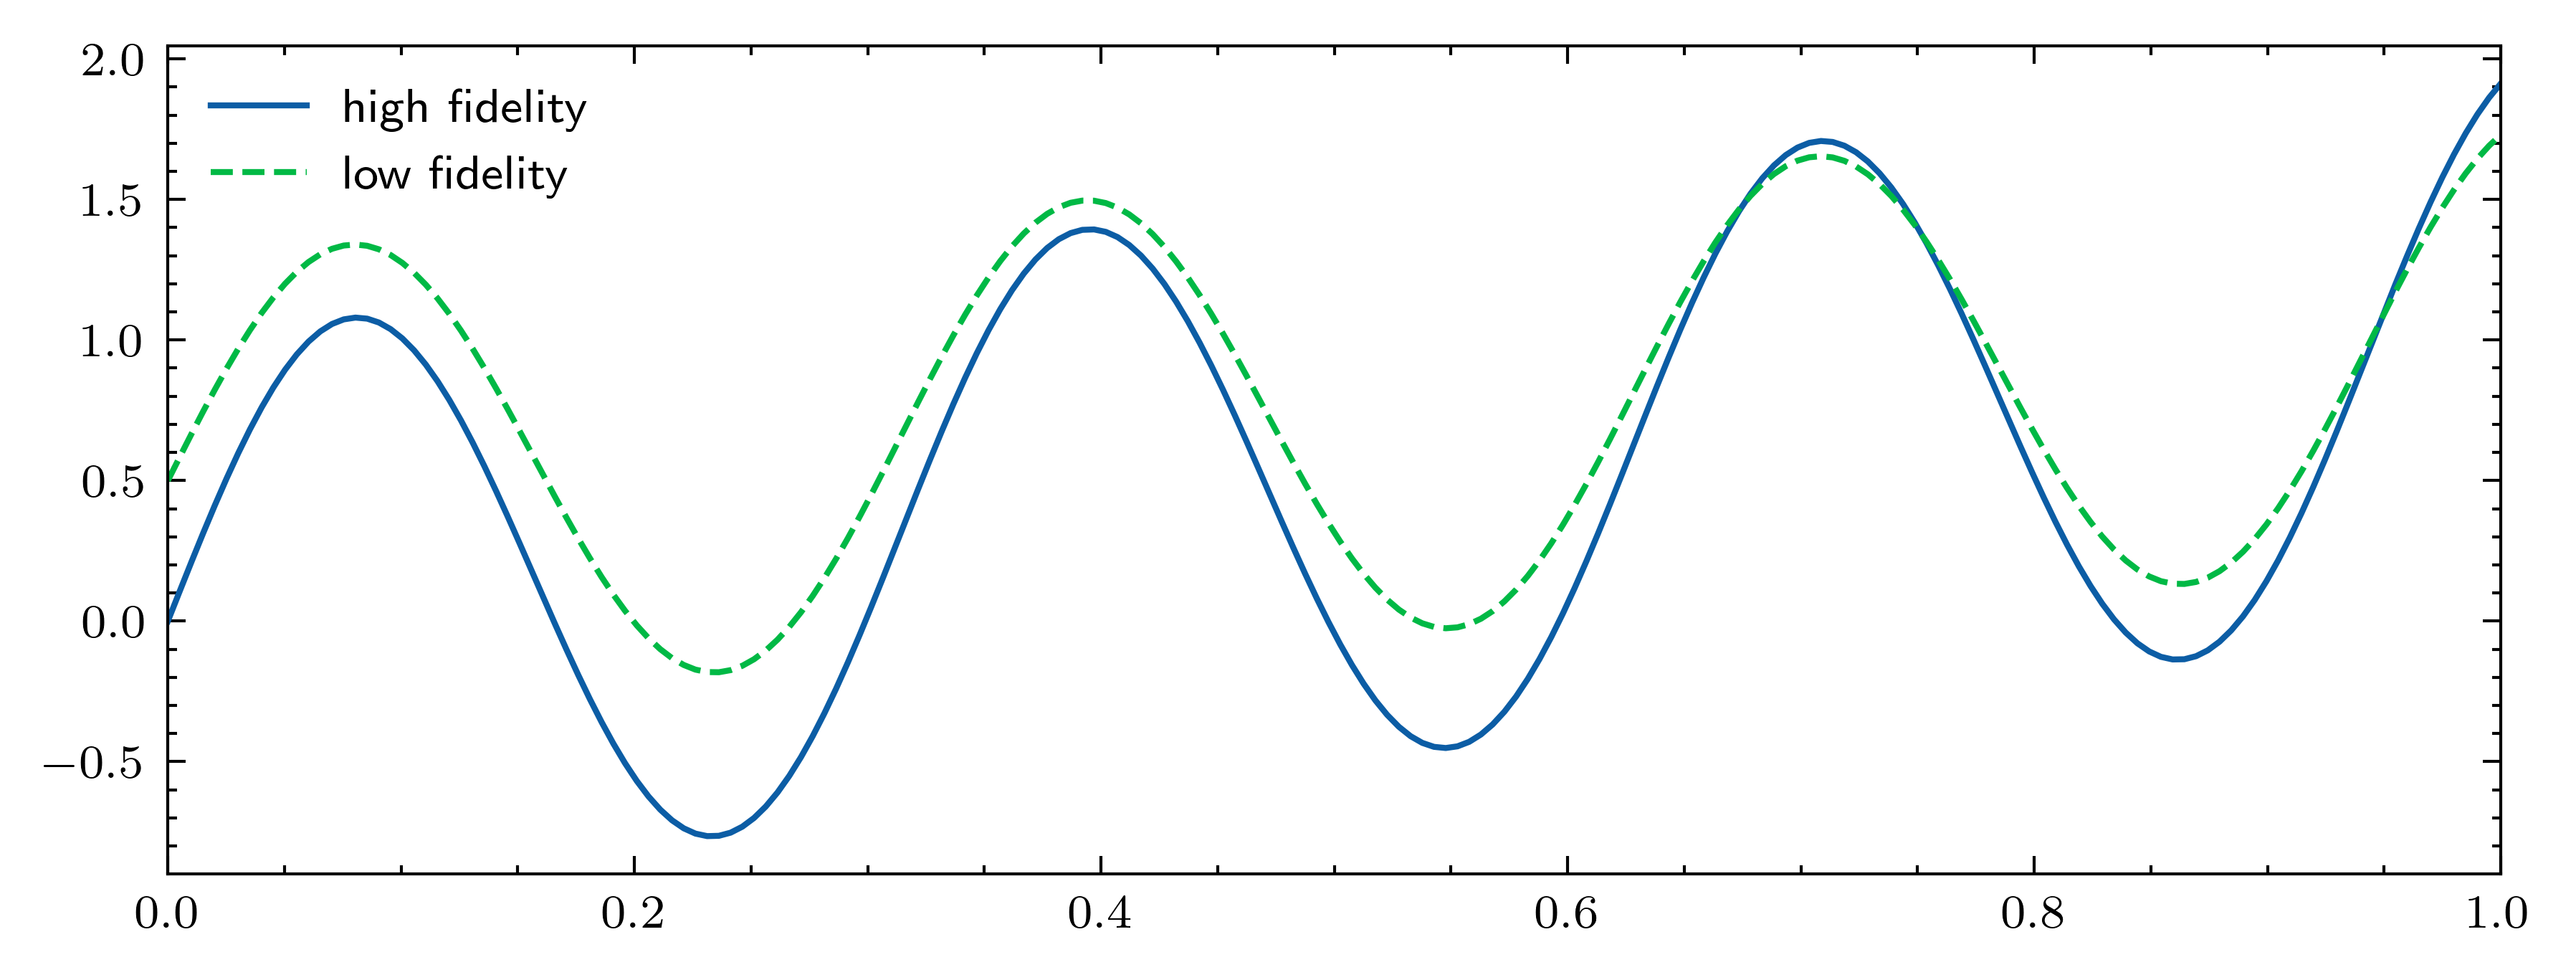

In [157]:

x_plot = np.linspace(start=0, stop=1, num=200)
with plt.style.context(["ieee", "science"]):
    fig = plt.figure(1)
    fig.set_size_inches(7,2.5)
    plt.plot(x_plot, f.hf(x=x_plot), label=f"high fidelity")
    plt.plot(x_plot, f.lf(x=x_plot), "--", label=f"low fidelity")
    plt.legend()
    #ax.set(xlabel=r"$x$")
    #ax.set(ylabel=r"$y$")
    plt.xlim(left=0., right=1.)
    # ax.autoscale(tight=True)
    fig.savefig('figs/test.tif', dpi=300)

sf_krg = Kriging(design_space=bound)
sf_krg.train(samples["hf"], sample_y["hf"])
co_krg = CoKriging(design_space=bound)


add_mf_krg = ScaledKriging(design_space=bound)
add_mf_krg.train(samples, sample_y)
co_krg.train(samples, sample_y)

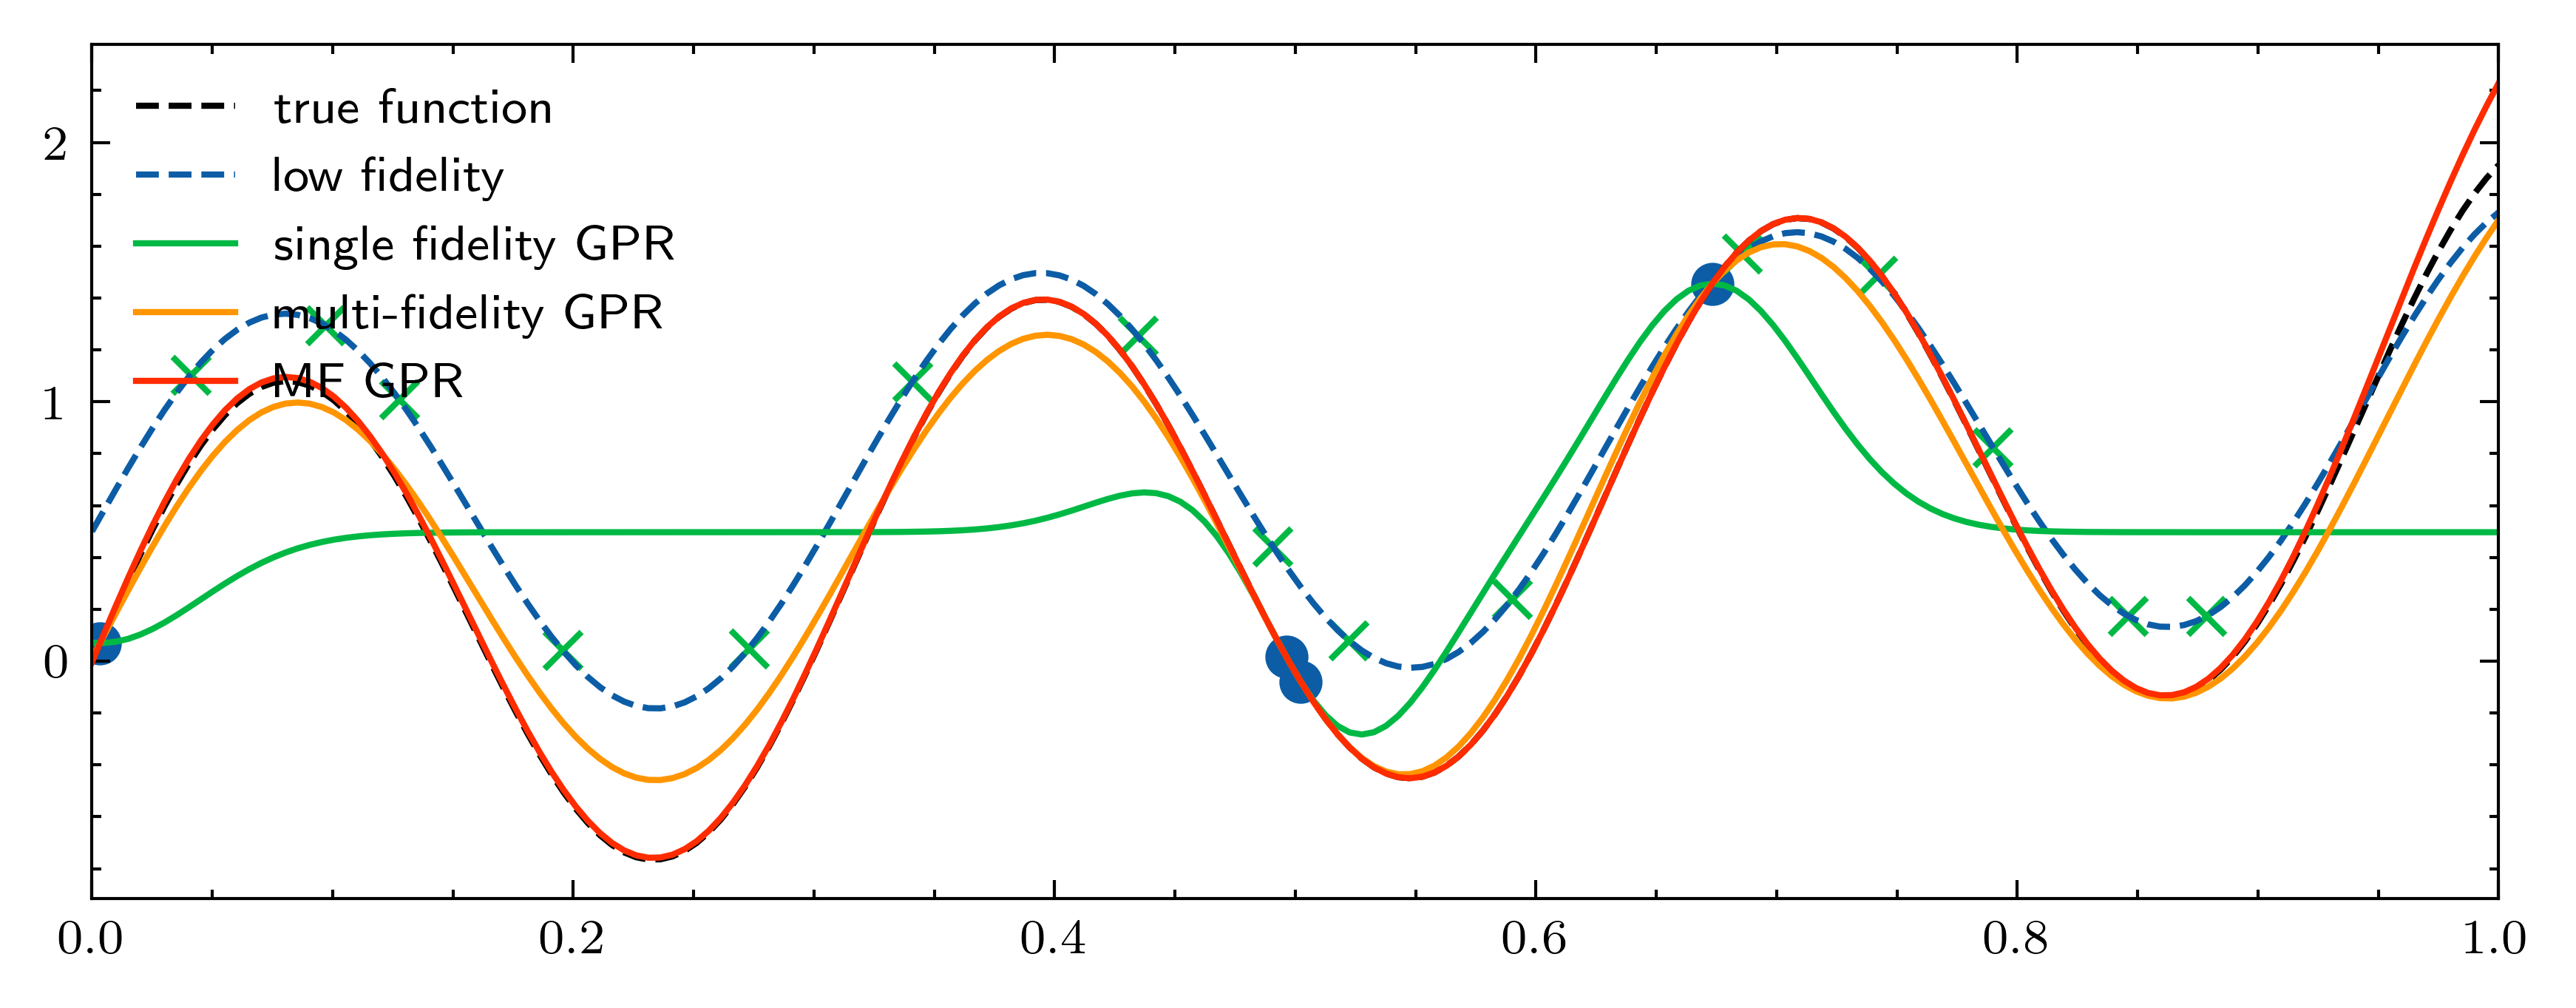

In [159]:

with plt.style.context(["ieee", "science"]):
    fig = plt.figure(2)
    fig.set_size_inches(7,2.5)
    plt.plot(x_plot, f.hf(x=x_plot), 'k--', label=f"true function")
    plt.plot(x_plot, f.lf(x=x_plot), "--", label=f"low fidelity")
    plt.scatter(samples['hf'], sample_y['hf'], marker='o')
    plt.scatter(samples['lf'], sample_y['lf'], marker='x')
    plt.plot(x_plot, sf_krg.predict(x_plot.reshape(-1, 1)), "-", label=f"single fidelity GPR")
    plt.plot(x_plot, add_mf_krg.predict(x_plot.reshape(-1, 1)), "-", label=f"multi-fidelity GPR")
    plt.plot(x_plot, co_krg.predict(x_plot.reshape(-1, 1)), "-", label=f"MF GPR")
    plt.legend()
    #ax.set(xlabel=r"$x$")
    #ax.set(ylabel=r"$y$")
    plt.xlim(left=0., right=1.)
    # ax.autoscale(tight=True)
    fig.savefig('figs/sf_mfadd.tif', dpi=300)

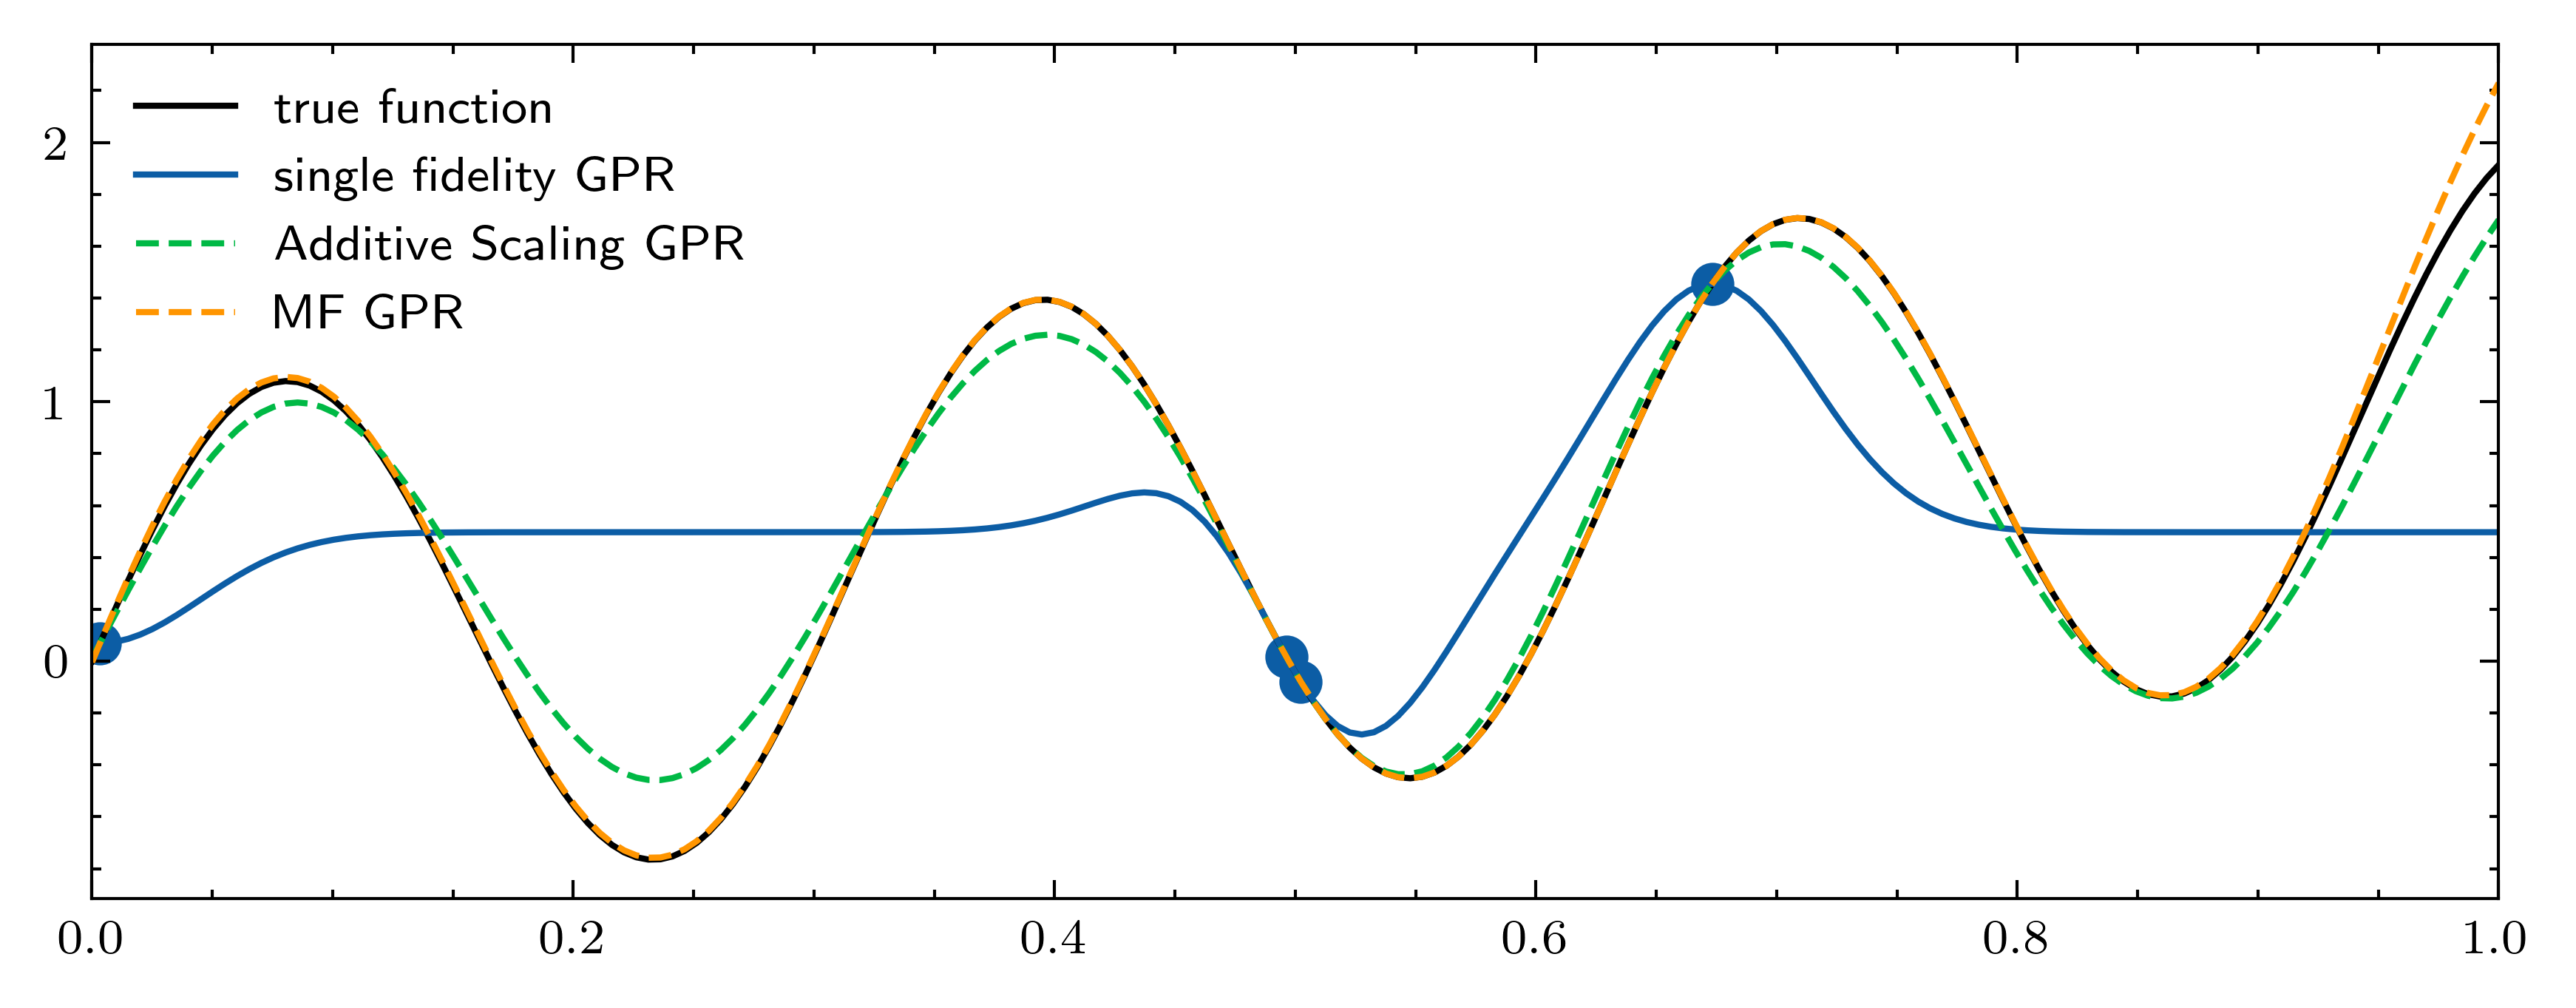

In [162]:
# co-krg
with plt.style.context(["ieee", "science"]):
    fig = plt.figure(2)
    fig.set_size_inches(7,2.5)
    plt.plot(x_plot, f.hf(x=x_plot), 'k-', label=f"true function")
    plt.scatter(samples['hf'], sample_y['hf'], marker='o')
    plt.plot(x_plot, sf_krg.predict(x_plot.reshape(-1, 1)), "-", label=f"single fidelity GPR")
    plt.plot(x_plot, add_mf_krg.predict(x_plot.reshape(-1, 1)), "--", label=f"Additive Scaling GPR")
    plt.plot(x_plot, co_krg.predict(x_plot.reshape(-1, 1)), "--", label=f"MF GPR")
    plt.legend()
    #ax.set(xlabel=r"$x$")
    #ax.set(ylabel=r"$y$")
    plt.xlim(left=0., right=1.)
    # ax.autoscale(tight=True)
    fig.savefig('figs/mfadd_co.tif', dpi=300)

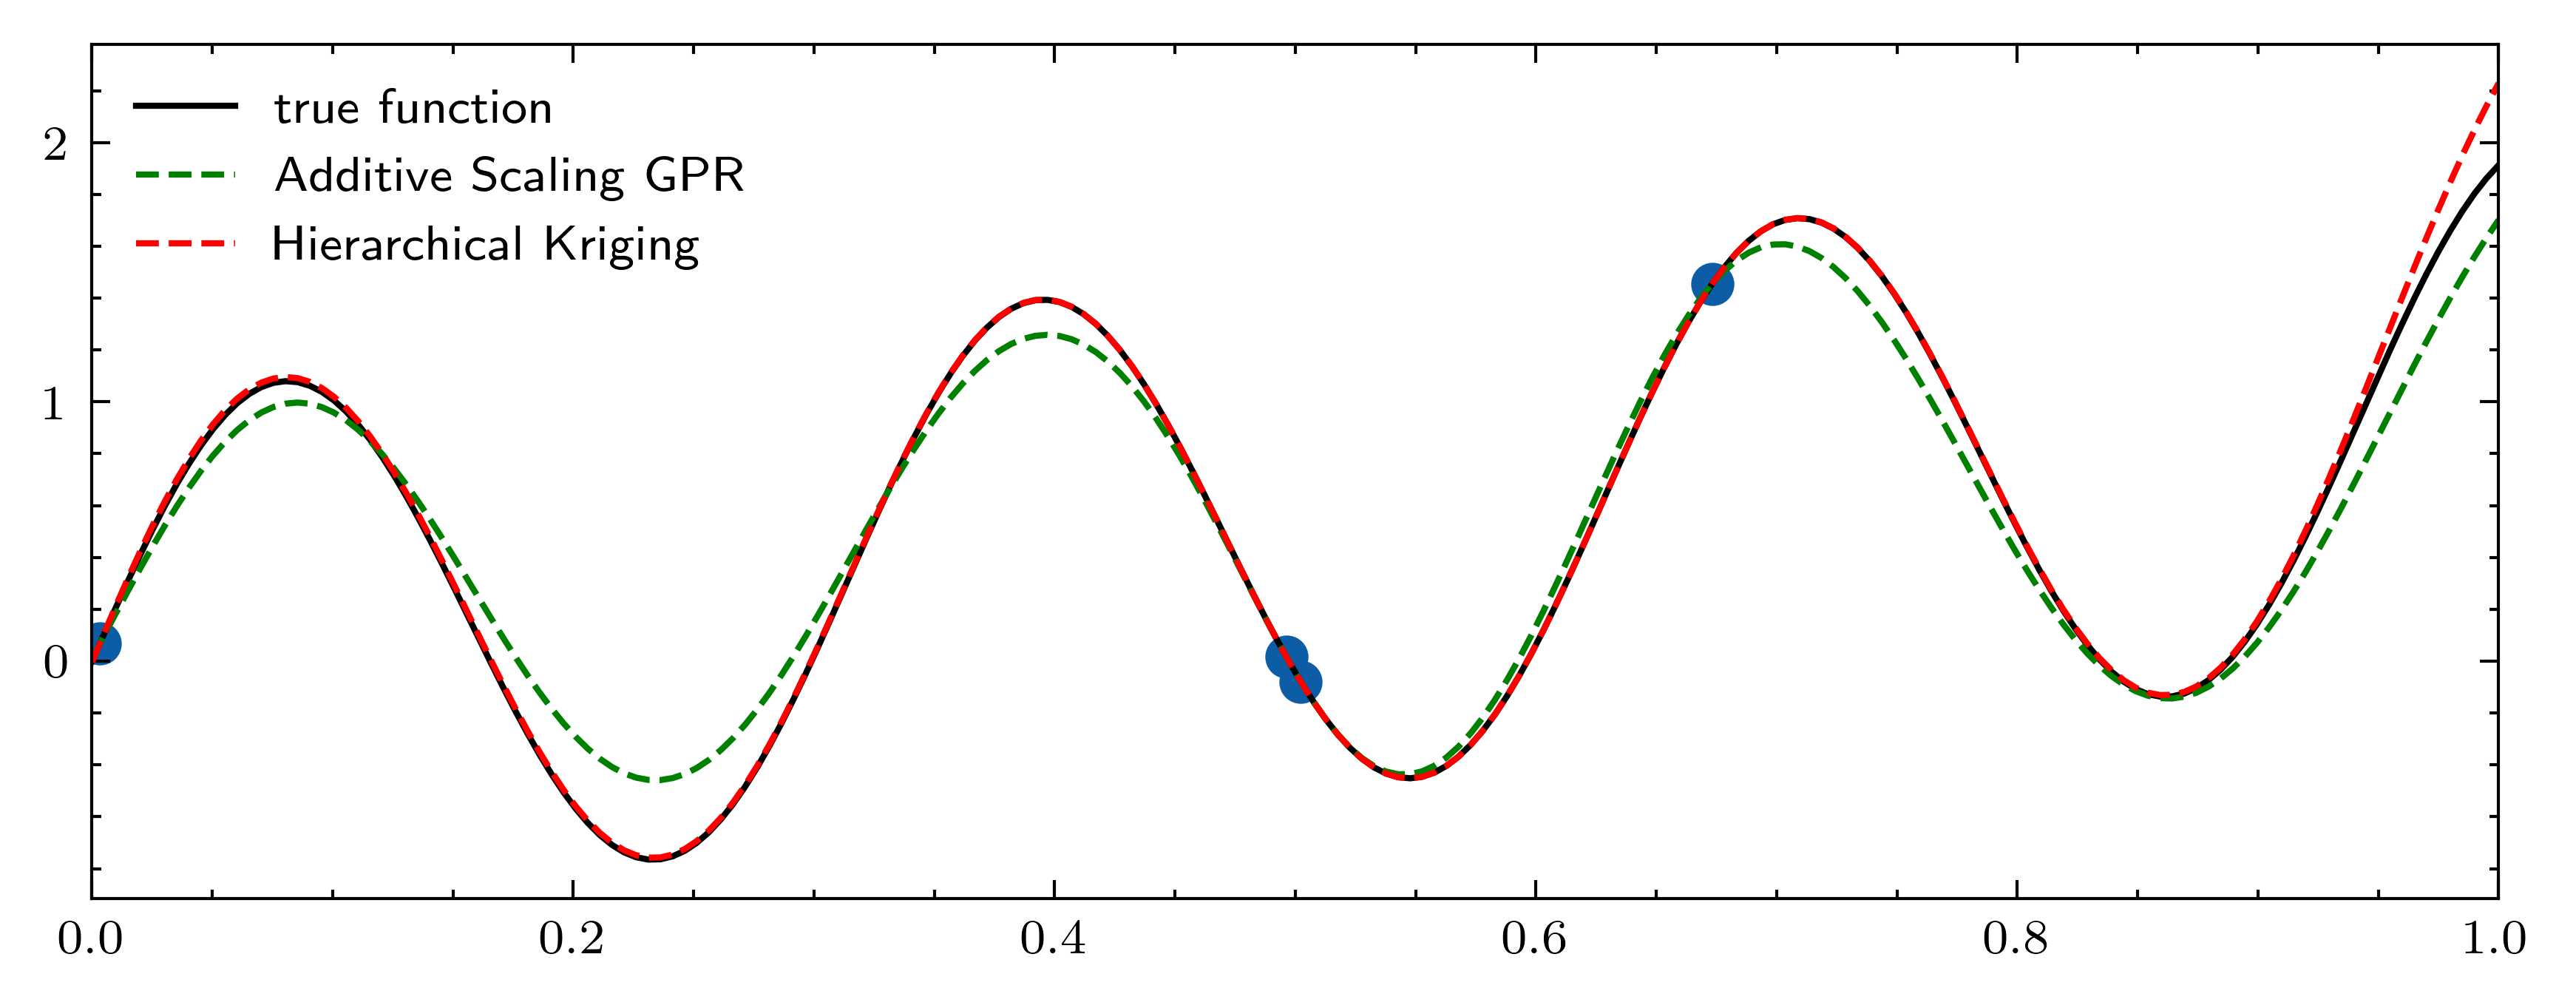

In [167]:
# HK
hk = HierarchicalKriging(design_space=bound)
hk.train(samples, sample_y)

with plt.style.context(["ieee", "science"]):
    fig = plt.figure(2)
    fig.set_size_inches(7,2.5)
    plt.plot(x_plot, f.hf(x=x_plot), 'k-', label=f"true function")
    plt.scatter(samples['hf'], sample_y['hf'], marker='o')
    plt.plot(x_plot, add_mf_krg.predict(x_plot.reshape(-1, 1)), "g--", label=f"Additive Scaling GPR")
    plt.plot(x_plot, hk.predict(x_plot.reshape(-1, 1)), "r--", label=f"Hierarchical Kriging")
    plt.legend()
    plt.xlim(left=0., right=1.)
    # ax.autoscale(tight=True)
    fig.savefig('figs/mfadd_hk.tif', dpi=300)


In [34]:
class fun2(MultiFidelityFunctions): 

    num_dim = 1
    num_obj = 1
    num_cons = 0
    input_domain: np.ndarray = np.array([[0.0, 1.0]])
    design_space: dict = {"x": [0.0, 1.0]}

    def __init__(self): 
        super().__init__()

    def hf(self, x):
        obj = np.power((6 * x - 2), 2) * np.sin(12 * x - 4)
        obj = np.reshape(obj, (x.shape[0], 1))
        return obj

    def lf(self, x):
        obj = 0.5 * np.power((5.8 * x - 2.1), 2) * np.sin(12 * x - 4) - 1
        obj = np.reshape(obj, (x.shape[0], 1))
        return obj

In [113]:
f = fun2()
design_space = f.design_space
bound = f._input_domain
## test sampling part
samples['lf'] = np.array([0., 0.08, 0.3, .4, .54, .78, .85, .93]).reshape(-1, 1)
samples['hf'] = np.array([.1, .4, .55, .78]).reshape(-1, 1)
#sampler.plot_samples(figure_name='test_sampling', save_plot=True)

# sample_x = samples["hf"].to_numpy()
sample_y = {}
sample_y["hf"] = f.hf(samples["hf"])
sample_y["lf"] = f.lf(samples["lf"])

add_error_krg = ScaledKriging(design_space=bound, rho_method='error', rho_optimize=False) 
add_bump_krg = ScaledKriging(design_space=bound, rho_method='bumpiness', rho_optimize=False)

add_error_krg.rho = 1.4
add_bump_krg.rho = 2.5

add_error_krg.train(samples, sample_y)
add_bump_krg.train(samples, sample_y)


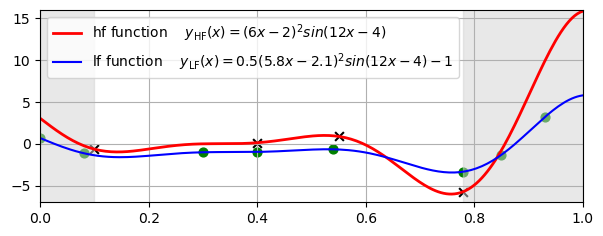

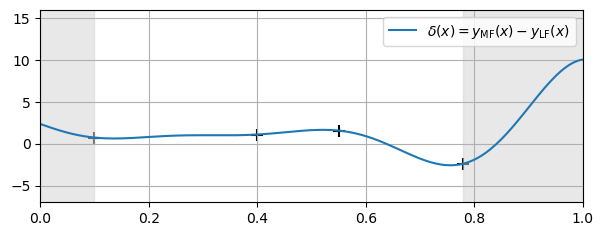

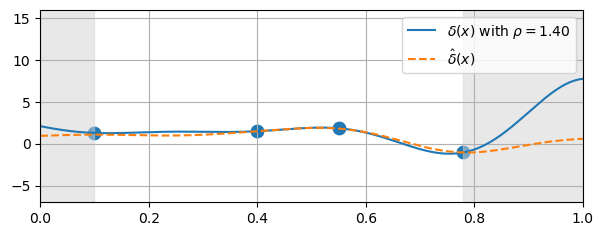

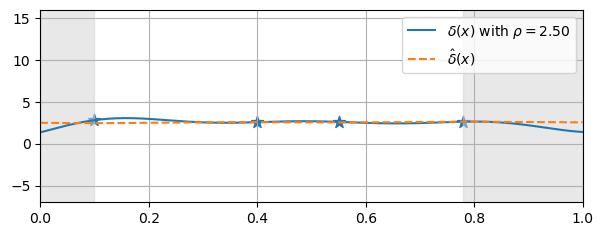

In [153]:
# fill 
x_fill_1 = np.linspace(.0, .1, 100)
x_fill_2 = np.linspace(.78, 1., 100)
y_1 = -20 
y_2 = 20

fig = plt.figure()
fig.set_size_inches(7,2.5)
plt.plot(x_plot, f.hf(x=x_plot), 'r-', linewidth=2, label=r"hf function $\quady_{\mathrm{HF}}(x)=(6x-2)^2sin(12x-4)$")
plt.plot(x_plot, f.lf(x=x_plot), 'b-', label=r"lf function $\quady_{\mathrm{LF}}(x)=0.5(5.8x-2.1)^2sin(12x-4)-1$")
plt.scatter(samples['hf'], sample_y['hf'], c='k', s=40, marker='x')
plt.scatter(samples['lf'], sample_y['lf'], c='g', s=40, marker='o')
plt.fill_between(x_fill_1, y_1, y_2, color='lightgrey', alpha=0.5)
plt.fill_between(x_fill_2, y_1, y_2, color='lightgrey', alpha=0.5)
plt.legend()
plt.xlim(left=0., right=1.)
plt.ylim([-7, 16])
plt.grid()

plt.savefig('figs/rho_1.tif', dpi=300)
# plot 2
fig = plt.figure()
fig.set_size_inches(7,2.5)
plt.plot(x_plot, f.hf(x=x_plot)-f.lf(x=x_plot), label=r"$\delta(x)=y_{\mathrm{MF}}(x)-y_{\mathrm{LF}}(x)$")
plt.scatter(samples['hf'], sample_y['hf'] - f.lf(samples['hf']), c='k', s=80, marker='+')
plt.fill_between(x_fill_1, y_1, y_2, color='lightgrey', alpha=0.5)
plt.fill_between(x_fill_2, y_1, y_2, color='lightgrey', alpha=0.5)
plt.legend()
plt.xlim(left=0., right=1.)
plt.ylim([-7, 16])
plt.grid()
plt.savefig('figs/rho_2.tif', dpi=300)
# plot 3
fig = plt.figure()
fig.set_size_inches(7,2.5)
plt.plot(x_plot, f.hf(x=x_plot)-add_error_krg.rho*f.lf(x=x_plot), \
         label=fr"$\delta(x)$ with $\rho={add_error_krg.rho:.2f}$")
plt.plot(x_plot, add_error_krg.disc_model.predict(x_plot.reshape(-1, 1)), '--',\
         label=r"$\hat{\delta}(x)$")
plt.scatter(samples['hf'], sample_y['hf'] - add_error_krg.rho*f.lf(samples['hf']), s=80)
plt.fill_between(x_fill_1, y_1, y_2, color='lightgrey', alpha=0.5)
plt.fill_between(x_fill_2, y_1, y_2, color='lightgrey', alpha=0.5)
plt.legend()
plt.xlim(left=0., right=1.)
plt.ylim([-7, 16])
plt.grid()
plt.savefig('figs/rho_3.tif', dpi=300)
# plot 4
fig = plt.figure()
fig.set_size_inches(7,2.5)
plt.plot(x_plot, f.hf(x=x_plot)-add_bump_krg.rho*f.lf(x=x_plot), \
         '-', label=fr"$\delta(x)$ with $\rho={add_bump_krg.rho:.2f}$")
plt.plot(x_plot, add_bump_krg.disc_model.predict(x_plot.reshape(-1, 1)), '--',\
         label=r"$\hat{\delta}(x)$")
plt.scatter(samples['hf'], sample_y['hf'] - add_bump_krg.rho*f.lf(samples['hf']), marker='*', s=80)
plt.fill_between(x_fill_1, y_1, y_2, color='lightgrey', alpha=0.5)
plt.fill_between(x_fill_2, y_1, y_2, color='lightgrey', alpha=0.5)
plt.legend()
plt.xlim(left=0., right=1.)
plt.ylim([-7, 16])
plt.grid()
plt.savefig('figs/rho_4.tif', dpi=300)
plt.show()